# Data Preprocessing and Visualisation

##### Installing and importing libraries

In [1]:
# library used for pairplots
!pip install -q seaborn

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# ensures that the entire width of the dataset can be displayed
pd.set_option('display.max_columns', None)

##### Loading the dataset

It is necessary to configure specific dtype for some columns, since their entries are ambiguous and contain both integers and strings.

In [3]:
dataset = pd.read_csv("data/BIT_AI_assignment_data.csv",
                      index_col=0,
                      dtype={"datasource": 'string',
                             "Model Series": 'string',
                             "Couple System": 'string',
                             "Grouser Tracks": 'string',
                             "Hydraulics Flow": 'string'})

(Optional) Since the dataset is quite large, its size can be reduced for testing.

In [4]:
# dataset = dataset.sample(frac=0.005, random_state=0)

##### Cleaning the data

In [5]:
print("Dataset shape:", dataset.shape)

Dataset shape: (412698, 53)


In order to gain more insight into the dataset, 3 first rows are printed.

In [6]:
dataset.head(3)

,Sales ID,Sales Price,Machine ID,Model ID,datasource,Auctioneer ID,Year Made,MachineHours CurrentMeter,Usage Band,Sales date,Model Description,Base Model,Secondary Description,Model Series,Model Descriptor,Machine Size,Product Class Description,State of Usage,Product Group,Product Group Description,Driver System,Enclosure,Control,Touchpad Type,Control Type,Version,Transmission,Turbo Charged,Extra features,Machine Width,Clean Room,Engine Horsepower,Hydraulics,Push Block,Ripper,Scarifier,Tip Control,Screen Size,Coupler,Couple System,Grouser Tracks,Hydraulics Flow,Tupper Type,Screen Size.1,Stick Length,Thumb,Pattern Changer,Grouser Type,Backhoe Mounting,Blade Type,Travel Possibilities,Differential Type,Steering Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,<NA>,NaN,NaN,Type E - 110.0 to 120.0 Horsepower,Alabama,WL,Germany,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Type E - 150.0 to 175.0 Horsepower,North Carolina,WL,Germany,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,<NA>,NaN,NaN,Type F - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,France,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Furthermore, the number of NaN values in each row is printed.

In [7]:
dataset.isna().sum()

Sales ID                          0
Sales Price                       0
Machine ID                        0
Model ID                          0
datasource                        0
Auctioneer ID                 20136
Year Made                         0
MachineHours CurrentMeter    265194
Usage Band                   339028
Sales date                        0
Model Description                 0
Base Model                        0
Secondary Description        140727
Model Series                 354031
Model Descriptor             337882
Machine Size                 216605
Product Class Description         0
State of Usage                    0
Product Group                     0
Product Group Description         0
Driver System                305611
Enclosure                       334
Control                      214983
Touchpad Type                331602
Control Type                 259970
Version                      331602
Transmission                 224691
Turbo Charged               

First of all, any rows that do not have an entry for the "Sales Price" variable must be dropped, as this is the response variable. Although this is not the case for the particular dataset being worked with, deletion should still be performed in case the model is trained on another dataset that contains empty "Sales Price" entries. Additionally, the columns "Sales ID", "Machine ID", and "Model ID" are not particularly useful as predictors and should also be dropped.

In [8]:
response_variable = ["Sales Price"]
dataset = dataset.dropna(subset=response_variable)
dataset = dataset.drop(columns=["Sales ID", "Machine ID", "Model ID"])

"Sales date" variables are converted to unix timestamps to make them processable for the model.

In [9]:
dataset["Sales Timestamp"] = pd.to_datetime(
    dataset["Sales date"]).view('int64') // 10**9
dataset = dataset.drop(columns=["Sales date"])

Numerical and categorical variables have to be specified.

In [10]:
numerical_variables = ["Year Made",
                       "MachineHours CurrentMeter",
                       "Sales Timestamp"]
categorical_variables = [variable for variable in dataset.columns
                         if variable not in numerical_variables
                         and variable not in response_variable]

Empty entries in the categorical variables are replaced with "None or Unspecified" to keep consistency with the rest of the dataset. Furthermore, amubiguous entries "#NAME?" are replaced with the same "None or Unspecified" flag.



In [11]:
dataset[categorical_variables] = dataset[categorical_variables].where(
    pd.notnull(dataset[categorical_variables]), "None or Unspecified")
dataset = dataset.replace("#NAME?", "None or Unspecified")

In order to gain insight into the dataset, a description table is created.

In [12]:
dataset[[variable for variable in (response_variable + numerical_variables)
         if variable != "Sales Timestamp"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales Price,412698.0,31215.181414,23141.743695,4750.0,14500.0,24000.0,40000.0,142000.0
Year Made,412698.0,1899.049637,292.190243,1000.0,1985.0,1995.0,2001.0,2014.0
MachineHours CurrentMeter,147504.0,3522.988285,27169.928650,0.0,0.0,0.0,3209.0,2483300.0


Numerical variables seem to contain some outliers. The minimal value of "Year Made" is 1000, which is obviously not possible. Moreover, the maximal value of "MachineHours CurrentMeter" is 2483300, which corresponds to over 283 years of continuous work. Such values need to be removed from the dataset. Furthermore, it can be noted that the "Year Made" column doesn't contain any empty entries,indicating that the value of 1000 could be a way of denoting an unknown values.

In [13]:
print("Number of entries equal to 1000 in the \"Year Made\" column:",
      dataset["Year Made"].value_counts()[1000])
dataset["Year Made"] = dataset["Year Made"].replace(1000, np.nan)

Number of entries equal to 1000 in the "Year Made" column: 39391


Indeed, the number of entries equal to 1000 is 39391, which is too large to be a mere error. Therefore, it is assumed that it is an intentional way of denoting unknown values. For now, they are replaced with NaN values and will be imputed later. In order to remove remaining outliers, all rows that contain entries with z-score above 10 are removed. It is quite a large margin, but the goal is to remove only the unrealistic values.

In [14]:
def remove_outliers(dataset, columns):
  max_zscore = 10
  def zscore(x):
    return np.abs((x - x.mean()) / x.std())

  for column in columns:
    dataset = dataset[np.logical_or(zscore(dataset[column]) < max_zscore,
                                    np.isnan(dataset[column]))]
  
  return dataset

dataset = remove_outliers(dataset, numerical_variables)

In order to verify the elimination of outliers, the description table is generated once again.

In [15]:
dataset[[variable for variable in (response_variable + numerical_variables)
         if variable != "Sales Timestamp"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales Price,412482.0,31215.564289,23141.337055,4750.0,14500.0,24000.0,40000.0,142000.0
Year Made,373136.0,1993.914251,9.689573,1919.0,1988.0,1996.0,2001.0,2014.0
MachineHours CurrentMeter,147288.0,2672.779697,8348.926282,0.0,0.0,0.0,3192.0,274900.0


After the outliers have been removed, the dataset looks significantly cleaner and the minimal and maximal values look realistic. At this point only "Year Made" and "MachineHours CurrentMeter" columns contain NaN values. Their number is quite significant, as they are present in over a half of the dataset. Therefore, they will have to be imputed.

Ideally, the data would be imputed with a more sophisticated algorithm, such as KNN. Unfortunately, KNN doesn't scale well for large dataset and hence implementing it in this particular case proved to be infeasible, considering the amount of available computational power. Therefore, data will be imputed by taking the mean of entries. This method is considered to be relatively accurate in this case, as the outliers have been removed.

In [16]:
dataset["Year Made"].fillna(
    value=dataset["Year Made"].mean(), inplace=True)
dataset["MachineHours CurrentMeter"].fillna(
    value=dataset["MachineHours CurrentMeter"].mean(), inplace=True)

Now, data types of the dataset can be examined.

In [17]:
dataset.dtypes

Sales Price                  float64
datasource                    string
Auctioneer ID                 object
Year Made                    float64
MachineHours CurrentMeter    float64
Usage Band                    object
Model Description             object
Base Model                    object
Secondary Description         object
Model Series                  string
Model Descriptor              object
Machine Size                  object
Product Class Description     object
State of Usage                object
Product Group                 object
Product Group Description     object
Driver System                 object
Enclosure                     object
Control                       object
Touchpad Type                 object
Control Type                  object
Version                       object
Transmission                  object
Turbo Charged                 object
Extra features                object
Machine Width                 object
Clean Room                    object
E

In order to be processed by the model, numerical variables have to be converted into floats and categorical variables into strings.

In [18]:
dataset[numerical_variables] = dataset[numerical_variables].astype(float)
dataset[categorical_variables] = dataset[categorical_variables].astype('string')

##### Creating training and test sets

Since the data is in a form of time series, it has to be approached chronologically. Sales date needs to be taken into account in order to model phenomena such as inflation. Moreover, it would be wrong to create training and test sets by sampling the dataset randomly, since it would essentially imply training on "future" data and testing on "past" data. The goal of training set is to confront the model with unseen data and simulate the real application as closely as possible. Therefore, the dataset is sorted by timestamp and subsequently splitted in a chronological manner.

In [19]:
dataset = dataset.sort_values(by=["Sales Timestamp"])

test_train_ratio = 0.8
train_dataset = dataset.head(round(test_train_ratio * dataset.shape[0]))
test_dataset = dataset.tail(round((1 - test_train_ratio) * dataset.shape[0]))

Furthermore, explanatory and prediction variables have to be separated.

In [20]:
x_train = train_dataset.drop(columns=response_variable)
x_test = test_dataset.drop(columns=response_variable)

y_train = train_dataset[response_variable]
y_test = test_dataset[response_variable]

##### Data visualisation

Numerical variables can be visualised on a pair plot in order to visualise relations between variables. 

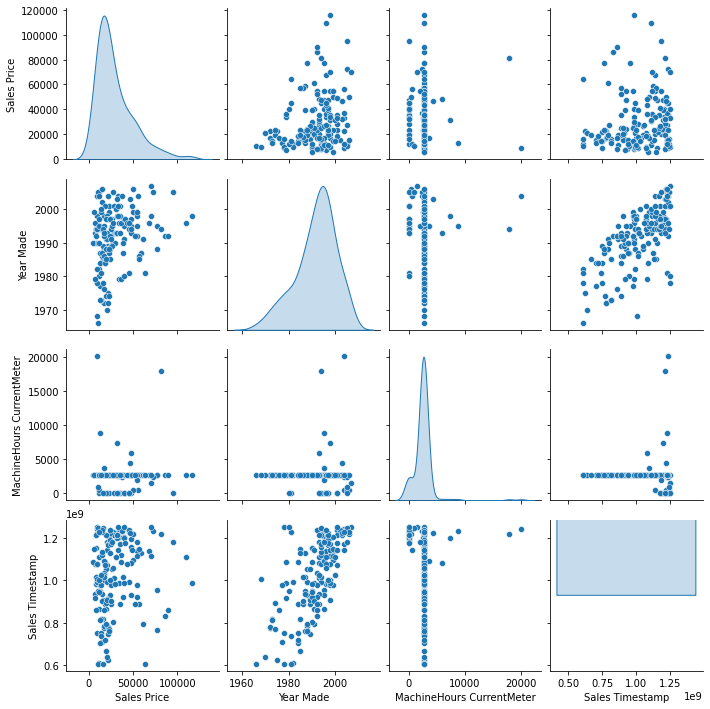

In [21]:
sns.pairplot(train_dataset[response_variable + numerical_variables].sample(
    frac=0.0005, random_state=0), diag_kind='kde')

The top row indicates that "Sales Price" is a function of other numerical variables.

# Modelling

##### Training normalisation and encoding layers

Since there is a lot of data avaialble, it is decided to use neural network to build the model. In order to ensure its universality, normalisation of numerical variables and encoding of categorical variables will be handled within the model's architecture. The former is achieved by a Keras' Normalisation layer and the latter by a Keras' StringLookup later. Encoding is created using the multi hot method, which encodes each sample in the input into a single array the same size as the vocabulary, containing a 1 for each vocabulary term present in the sample.

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x_train[numerical_variables])

encoder = layers.StringLookup(output_mode='multi_hot')
encoder.adapt(x_train[categorical_variables])

##### Building the model

The model begins with 2 input layers that receive numerical and categorical variables. These inputs are then converted by their respective preprocessing layers and contatenated into one tensor. This tensor is then passed to 4 dense layers that calculate the output. In order to prevent overfitting, l2 regularisation as well as dropout layers are implemented. Mean absolute error is selected as loss function.

In [ ]:
def build_and_compile_model():
  input_numerical = layers.Input(shape=(3,))
  input_categorical = layers.Input(shape=(46,), dtype=tf.string)
  
  input_numerical_normalized = normalizer(input_numerical)
  input_categorical_encoded = encoder(input_categorical)

  x = layers.Concatenate(axis=1)([input_numerical_normalized,
                                  input_categorical_encoded])

  x = layers.Dense(256, activation='relu',
                   kernel_regularizer=regularizers.l2(0.0001))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(256, activation='relu',
                   kernel_regularizer=regularizers.l2(0.0001))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(64, activation='relu',
                   kernel_regularizer=regularizers.l2(0.0001))(x)
  x = layers.Dropout(0.5)(x)
  output = layers.Dense(1)(x)

  model = keras.Model(inputs=[input_numerical,input_categorical],
                      outputs=output)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 46)]         0           []                               
                                                                                                  
 normalization (Normalization)  (None, 3)            7           ['input_1[0][0]']                
                                                                                                  
 string_lookup (StringLookup)   (None, 5565)         0           ['input_2[0][0]']                
                                                                                              

##### Training the model

Model weights are saved after each epoch as a checkpoint.

In [ ]:
%%time
checkpoint_path = "training/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

history = model.fit(
    [x_train[numerical_variables],
     x_train[categorical_variables]],
     y_train,
     verbose=1,
     batch_size=256,
     epochs=50,
     callbacks=[cp_callback],
     validation_data=([x_test[numerical_variables],
                       x_test[categorical_variables]],
                       y_test))

Epoch 1/50
1290/1290 [==============================] - ETA: 0s - loss: 10465.9336
Epoch 1: val_loss improved from inf to 7344.12646, saving model to drive/MyDrive/Bit/training/cp.ckpt
1290/1290 [==============================] - 186s 143ms/step - loss: 10465.9336 - val_loss: 7344.1265
Epoch 2/50
1290/1290 [==============================] - ETA: 0s - loss: 7491.4077
Epoch 2: val_loss improved from 7344.12646 to 7069.86035, saving model to drive/MyDrive/Bit/training/cp.ckpt
1290/1290 [==============================] - 183s 142ms/step - loss: 7491.4077 - val_loss: 7069.8604
Epoch 3/50
1290/1290 [==============================] - ETA: 0s - loss: 7262.4370
Epoch 3: val_loss improved from 7069.86035 to 6643.18604, saving model to drive/MyDrive/Bit/training/cp.ckpt
1290/1290 [==============================] - 186s 144ms/step - loss: 7262.4370 - val_loss: 6643.1860
Epoch 4/50
1290/1290 [==============================] - ETA: 0s - loss: 7139.1475
Epoch 4: val_loss did not improve from 6643.186

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='test_loss')
  plt.xlabel('Epoch')
  plt.ylabel("MSE [Sales Price]")
  plt.legend()
  plt.grid(True)

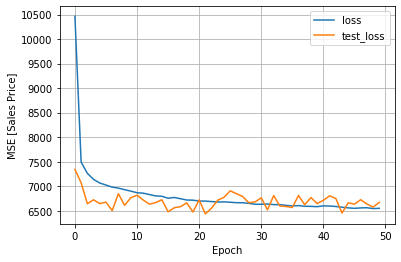

In [ ]:
plot_loss(history)

Training and test losses are plotted above. The test loss exhibits considerable fluctuations, which are likely due to a relatively large batch size that was chosen because of limited computational resources. Nonetheless, if there is access to more computational power, it is advisable to train the model again using a reduced batch size.



# Testing

##### Saving and loading the model

In [ ]:
model.save("model")

In [22]:
model = tf.keras.models.load_model("model")

##### Evaluating performance

In [23]:
test_mse = model.evaluate([x_test[numerical_variables],
                           x_test[categorical_variables]],
                           y_test,
                           verbose=0)

print("Test MSE:", test_mse)

Test MSE: 6669.7548828125


In order to gain more insight into the nature of model's errors, they will be visualised.

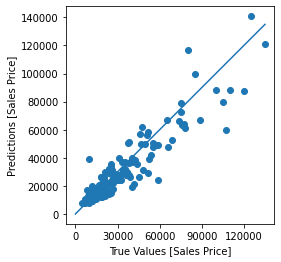

In [24]:
y_predictions = model.predict([x_test[numerical_variables],
                               x_test[categorical_variables]],
                               verbose=0).flatten()

# randomly sample 150 data points to make the plot readable
np.random.seed(0)
indices = np.random.choice(len(y_predictions), 150, replace=False)

a = plt.axes(aspect='equal')
plt.scatter(y_test.to_numpy()[indices], y_predictions[indices])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30000))
plt.xlabel("True Values [Sales Price]")
plt.ylabel("Predictions [Sales Price]")
lims = [0, np.max(y_test.to_numpy()[indices])]
_ = plt.plot(lims, lims)

As can be seen on the graph, model's predictions are reasonably accurate, especially when the true price is low.

Mean error: -2193.851516981694


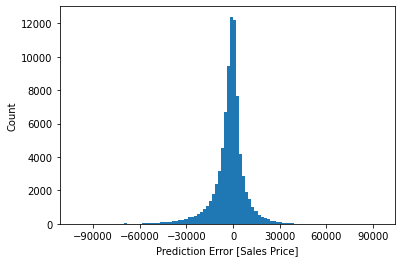

In [25]:
error = y_predictions - np.squeeze(y_test.to_numpy())

plt.hist(error, bins=100)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30000))
plt.xlabel("Prediction Error [Sales Price]")
_ = plt.ylabel("Count")

print("Mean error:", np.mean(error))

It appears the the model is slightly biased towards underestimating the price.